In [51]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas.plotting import lag_plot

This program investigates whether the size of Fair Value Gaps (FVGs) can predict future price movements.

It detects bullish and bearish FVGs in historical price data, measures their magnitude, and tests their relationship to the next period’s return using linear regression and a permutation test.

The goal is to determine if larger FVGs are statistically significant indicators of short-term price direction.

[*********************100%***********************]  1 of 1 completed


                            OLS Regression Results                            
Dep. Variable:      1 Period % Change   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     7.562
Date:                Thu, 10 Jul 2025   Prob (F-statistic):            0.00600
Time:                        17:40:27   Log-Likelihood:                 7889.4
No. Observations:                2646   AIC:                        -1.577e+04
Df Residuals:                    2644   BIC:                        -1.576e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.767      0.0

Price,Adj Close,Close,High,Low,Open,Volume,Close + 1,1 Period % Change,High_2prev,Bull_FVG,Bull_FVG_Val,Low_2prev,Bear_FVG,Bear_FVG_Val,Sum_FVG,Predictions,Residuals
2,24.605864,44.343750,44.375000,44.125000,44.218750,201300,44.812500,0.010571,43.968750,1,0.003524,43.750000,0,0.000000,0.003524,-0.073240,0.083811
3,24.865974,44.812500,44.843750,44.375000,44.406250,529400,45.000000,0.004184,44.250000,1,0.002789,43.968750,0,0.000000,0.002789,-0.073240,0.077424
4,24.970013,45.000000,45.093750,44.468750,44.968750,531500,44.968750,-0.000694,44.375000,1,0.002083,44.125000,0,0.000000,0.002083,-0.073241,0.072546
8,24.813961,44.718750,44.750000,44.531250,44.656250,379600,44.937500,0.004892,45.125000,0,-0.000000,44.906250,1,-0.003494,-0.003494,-0.073243,0.078135
11,24.120329,43.468750,44.468750,43.406250,44.468750,374800,43.437500,-0.000719,45.125000,0,-0.000000,44.781250,1,-0.007189,-0.007189,-0.073244,0.072526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8158,614.909973,614.909973,616.390015,610.830017,612.880005,86258400,617.849976,0.004781,608.609985,1,0.003610,605.539978,0,0.000000,0.003610,-0.073240,0.078021
8159,617.849976,617.849976,619.219971,615.039978,617.380005,92502500,617.650024,-0.000324,612.309998,1,0.004419,608.369995,0,0.000000,0.004419,-0.073240,0.072916
8162,625.340027,625.340027,626.280029,622.429993,622.450012,51065800,620.679993,-0.007452,618.830017,1,0.005757,615.520020,0,0.000000,0.005757,-0.073239,0.065787
8164,620.340027,620.340027,622.109985,619.520020,621.349976,59024600,624.059998,0.005997,626.280029,0,-0.000000,622.429993,1,-0.000516,-0.000516,-0.073242,0.079238


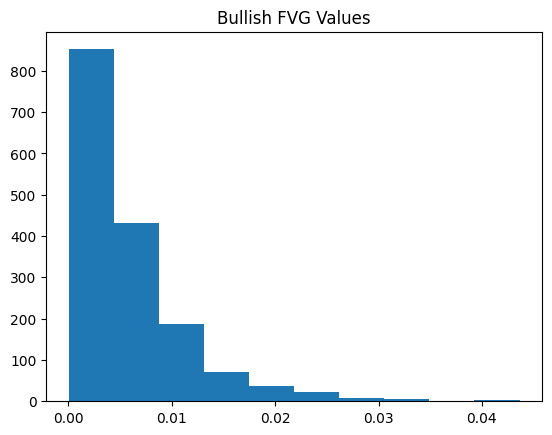

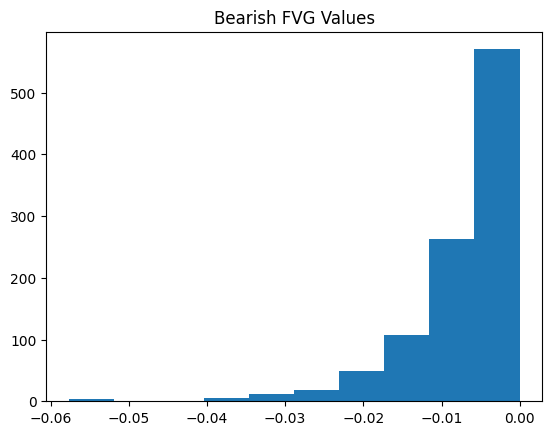

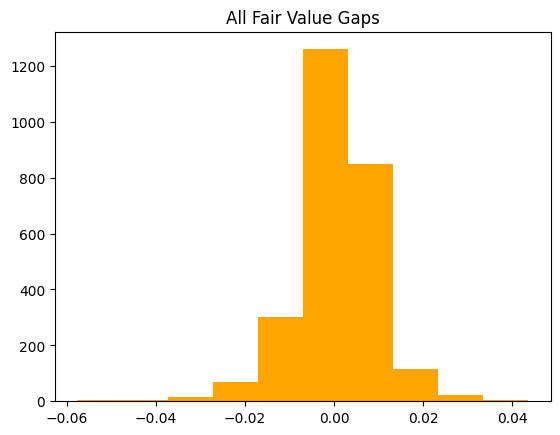

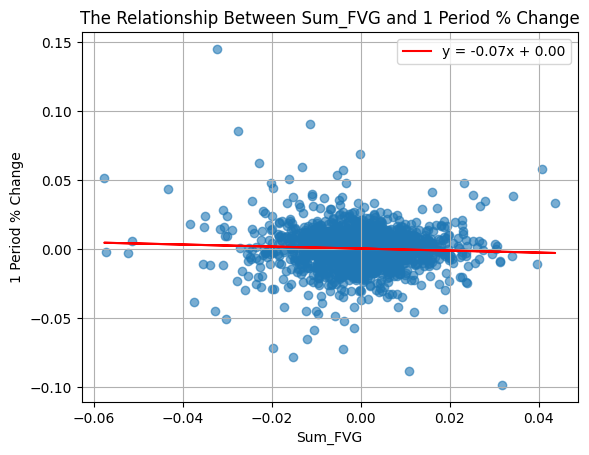

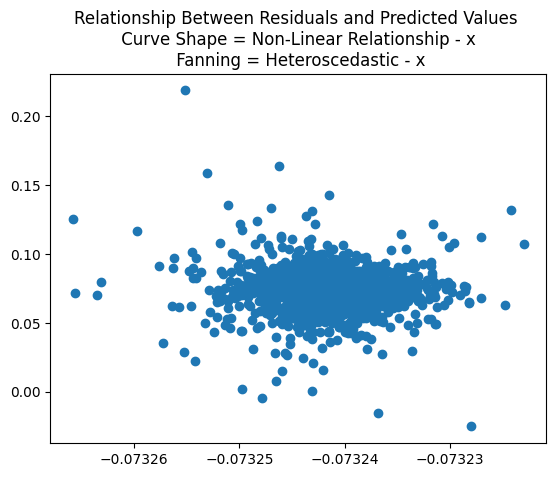

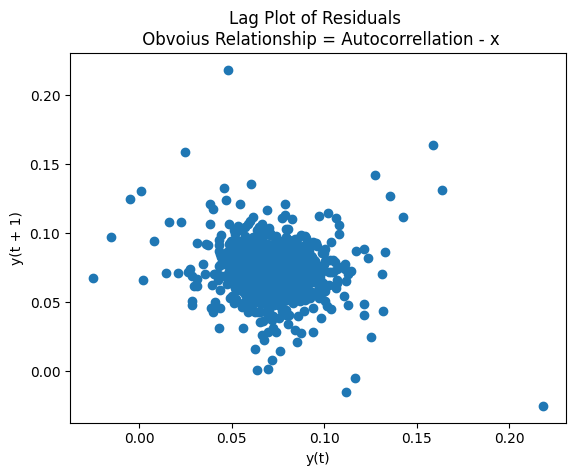

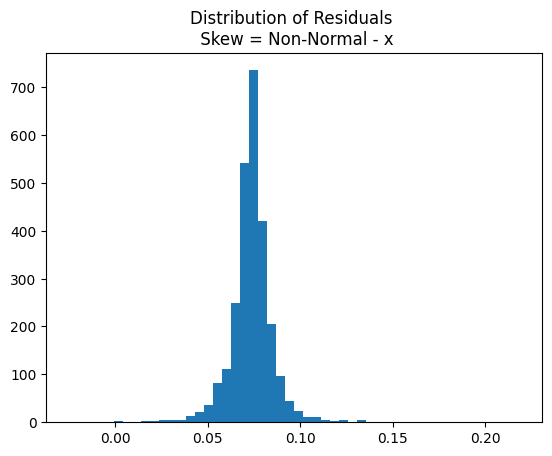

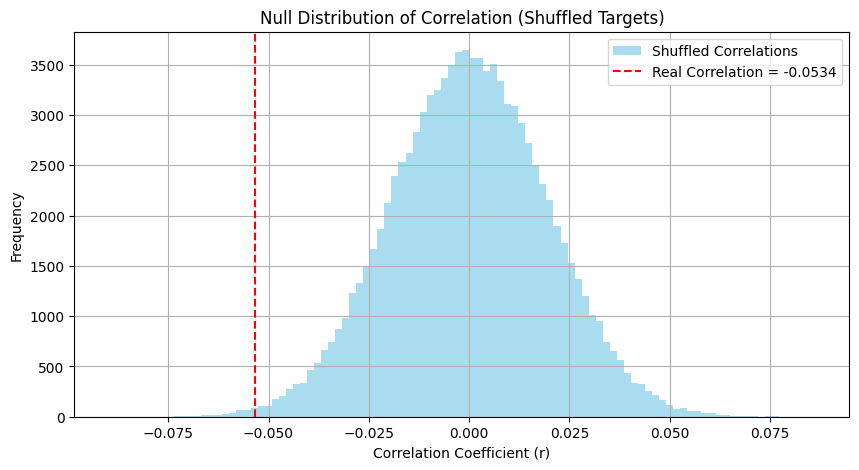

In [52]:
# General parameters
TICKER = 'SPY'
INTERVAL = '1d'
SHIFT = 1
STRATEGY = 'Sum_FVG'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

# subsection of data we are interested
LOOKBACK = 10000

def get_data(ticker = TICKER, lookback = LOOKBACK, interval = INTERVAL):

    # get data at interval
    df = yf.download(ticker, interval = interval, period = PERIOD, auto_adjust = False) 
    df.columns = df.columns.get_level_values(0)

    df = df.reset_index(drop = True) # Changes dates to numbers so we don't have weird weekend gaps when plotting

    return df.iloc[-lookback:,:] #Take a piece of the last "LOOKBACK" rows

def add_target(df, shift = SHIFT):

    df[f'Close + {shift}'] = df['Close'].shift(-shift) 
    df[f'{shift} Period % Change'] = (df[f'Close + {shift}'] - df['Close']) / df['Close'] # * 100
    
    return df

def bull_fvg(df):
    # The low price of today > high price two candles ago
    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Bull_FVG'] * (df['Low'] - df['High_2prev'])) / df['Close']

    FVGs = df[df['Bull_FVG_Val'] > 0] 

    plt.hist(FVGs['Bull_FVG_Val'], bins = 10)
    plt.title('Bullish FVG Values')

    return df

def bear_fvg(df):
    # The high price of today < low price two candles ago
    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['Bear_FVG'] * (df['High'] - df['Low_2prev'])) / df['Close']

    FVGs = df[df['Bear_FVG_Val'] < 0] 

    plt.figure()
    plt.hist(FVGs['Bear_FVG_Val'], bins = 10)
    plt.title('Bearish FVG Values')

    return df

def prepared_df_for_regression(df):
    df = df[(df['Bull_FVG'] == 1) | (df['Bear_FVG'] == 1)].copy()
    df['Sum_FVG'] = df['Bull_FVG_Val'] + df['Bear_FVG_Val']

    plt.figure()
    plt.hist(df['Sum_FVG'], color = 'orange')
    plt.title('All Fair Value Gaps')

    return df

def generate_regression_output(df, features=f'{STRATEGY}', target = f'{SHIFT} Period % Change'):
    # Create a subset of the dataframe with just the selected features and target, dropping rows with missing values
    subset = df[[features, target]].dropna()

    # Independent variable (feature) and dependent variable (target)
    X = subset[features]
    y = subset[target]

    # Add a constant term (intercept) to the feature set
    X_with_const = sm.add_constant(X)

    # Fit an Ordinary Least Squares (OLS) linear regression model
    model = sm.OLS(y, X_with_const).fit()

    # Extract the intercept and slope (coefficient) from the model
    intercept = model.params['const']
    coef = model.params[features]

    # Generate predicted y-values using the fitted model
    y_pred = model.predict(X_with_const)

    # Print a detailed summary of the regression results in the console
    print(model.summary())

    # Plot the data and the regression line
    plt.figure()
    plt.title(f'The Relationship Between {features} and {target}')

    # Plot the regression line
    plt.plot(X, y_pred, color='red', label=f'y = {coef:.2f}x + {intercept:.2f}')
    
    # Scatter plot of the actual data points
    plt.scatter(X, y, alpha=0.6)

    # Add labels, legend, and grid for clarity
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")
    plt.legend()
    plt.grid(True)

    return df, intercept, coef

def validation_reg(df, coef, intercept, strategy = STRATEGY):

    df['Predictions'] = intercept + coef * df[f'{strategy}'] 
    df['Residuals'] = df[f'{SHIFT} Period % Change'] - df['Predictions']

    # Linearity and Homoscedastidy
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Relationship Between Residuals and Predicted Values \n ' \
        'Curve Shape = Non-Linear Relationship - x \n ' \
        'Fanning = Heteroscedastic - x')

    # Independece (autocorrolation)
    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals \n Obvoius Relationship = Autocorrellation - x')

    # Normality
    plt.figure()
    plt.hist(df['Residuals'], bins = 50)
    plt.title('Distribution of Residuals \n Skew = Non-Normal - x')

    return df

def assess_regression_output(df, coef, features=f'{STRATEGY}', target=f'{SHIFT} Period % Change', n=100000):
    # Create a subset of the dataframe with only the feature and target columns, drop missing values
    subset = df[[features, target]].dropna()

    # Define X (independent variable) and y (dependent variable)
    X = subset[features]
    y = subset[target]

    # Calculate the real Pearson correlation coefficient between X and y
    real_r = np.corrcoef(X, y)[0, 1]
    correlations = []  # list to store correlations under null hypothesis

    # Run the permutation test n times
    for _ in range(n):
        # Randomly shuffle the y values (break any real association with X)
        shuffled_y = np.random.permutation(y)

        # Calculate the correlation between X and the shuffled y
        r = np.corrcoef(X, shuffled_y)[0, 1]
        correlations.append(r)

    # Plot the null distribution of correlations
    plt.figure(figsize=(10, 5))
    plt.hist(correlations, bins=100, alpha=0.7, color='skyblue', label='Shuffled Correlations')

    # Add a vertical line showing the real observed correlation
    plt.axvline(real_r, color='red', linestyle='--', label=f'Real Correlation = {real_r:.4f}')

    plt.title('Null Distribution of Correlation (Shuffled Targets)')
    plt.xlabel('Correlation Coefficient (r)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

    return df


def main():
    df = get_data()
    df = add_target(df)
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = prepared_df_for_regression(df)
    df, fit_coef, fit_intercept = generate_regression_output(df)
    df = validation_reg(df, coef = fit_coef, intercept = fit_intercept)
    df = assess_regression_output(df, coef=fit_coef)

    return df

df = main()
df